In [1]:
from __future__ import division
import time
import torch 
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import cv2 
from util import *
from darknet import Darknet
from preprocess import prep_image, inp_to_image
import pandas as pd
import random 
import argparse
import pickle as pkl
from matplotlib import pyplot as plt

In [2]:

def write(x, img):
    c1 = tuple(x[1:3].int())
    c2 = tuple(x[3:5].int())
    cls = int(x[-1])
    label = "{0}".format(classes[cls])
    color = random.choice(colors)
    cv2.rectangle(img, c1, c2,color, 1)
    t_size = cv2.getTextSize(label, cv2.FONT_HERSHEY_PLAIN, 1 , 1)[0]
    c2 = c1[0] + t_size[0] + 3, c1[1] + t_size[1] + 4
    cv2.rectangle(img, c1, c2,color, -1)
    cv2.putText(img, label, (c1[0], c1[1] + t_size[1] + 4), cv2.FONT_HERSHEY_PLAIN, 1, [225,255,255], 1);
    return img

def arg_parse():
    """
    Parse arguements to the detect module
    
    """
    
    
    parser = argparse.ArgumentParser(description='YOLO v3 Cam Demo')
    parser.add_argument("--confidence", dest = "confidence", help = "Object Confidence to filter predictions", default = 0.25)
    parser.add_argument("--nms_thresh", dest = "nms_thresh", help = "NMS Threshhold", default = 0.4)
    parser.add_argument("--reso", dest = 'reso', help = 
                        "Input resolution of the network. Increase to increase accuracy. Decrease to increase speed",
                        default = "160", type = str)
    return parser.parse_args()

def prep_image(img, inp_dim):
    """
    Prepare image for inputting to the neural network. 
    
    Returns a Variable 
    """

    orig_im = img
    dim = orig_im.shape[1], orig_im.shape[0]
    img = cv2.resize(orig_im, (inp_dim, inp_dim))
    img_ = img[:,:,::-1].transpose((2,0,1)).copy()
    img_ = torch.from_numpy(img_).float().div(255.0).unsqueeze(0)
    return img_, orig_im, dim

In [3]:
cfgfile = "cfg/yolov3.cfg"
weightsfile = "yolov3.weights"
num_classes = 80

ARGS_CONFIDENCE = 0.4
ARGS_THRESH = 0.4
ARGS_HEIGHT = 160

confidence = float(ARGS_CONFIDENCE)
nms_thesh = float(ARGS_THRESH)
start = 0


    
    
num_classes = 80
bbox_attrs = 5 + num_classes

model = Darknet(cfgfile)
model.load_weights(weightsfile)

model.net_info["height"] = ARGS_HEIGHT

inp_dim = int(model.net_info["height"])
CUDA = torch.cuda.is_available()

model.cuda()
            
# model.eval()

classes = load_classes('data/coco.names')
colors = pkl.load(open("pallete", "rb"))

In [4]:
frame = cv2.imread('imgs/giraffe.jpg',cv2.IMREAD_COLOR)
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

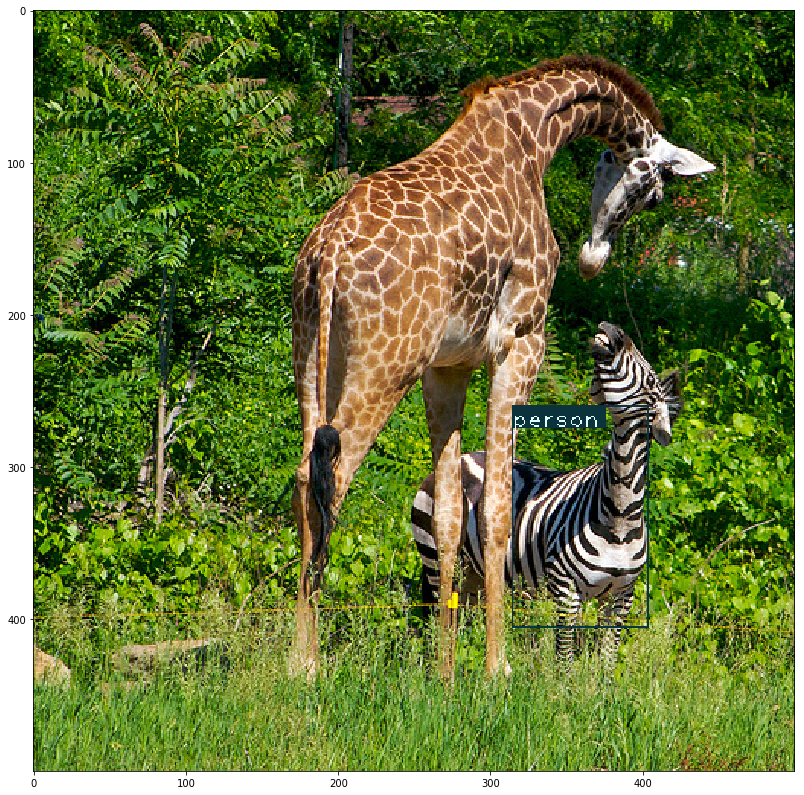

In [5]:




img, orig_im, dim = prep_image(frame, inp_dim)


im_dim = torch.FloatTensor(dim).repeat(1,2)                        



im_dim = im_dim.cuda()
img = img.cuda()


output = model(Variable(img), CUDA)
output = write_results(output, confidence, num_classes, nms = True, nms_conf = nms_thesh)





output[:,1:5] = torch.clamp(output[:,1:5], 0.0, float(inp_dim))/inp_dim

im_dim = im_dim.repeat(output.size(0), 1)
output[:,[1,3]] *= frame.shape[1]
output[:,[2,4]] *= frame.shape[0]


list(map(lambda x: write(x, orig_im), output))

plt.figure(figsize=(28,14))
imgplot = plt.imshow(orig_im)
plt.show()
